In [1]:
from lightgbm import LGBMClassifier
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import StandardScaler

### Load data

In [2]:
raw_data = pd.read_csv('../Dataset/DSA4263_data_raw.csv')



### Dropping unnecessary features

In [3]:
raw_data.drop(['nameOrig', 'nameDest','isFlaggedFraud'], axis=1, inplace=True)
raw_data.columns

Index(['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
       'oldbalanceDest', 'newbalanceDest', 'isFraud'],
      dtype='object')

In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   oldbalanceOrg   float64
 4   newbalanceOrig  float64
 5   oldbalanceDest  float64
 6   newbalanceDest  float64
 7   isFraud         int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 388.3+ MB


In [5]:
raw_data['type'].replace({'CASH_OUT':0, 'PAYMENT':1, 'CASH_IN':2, 'TRANSFER':3, 'DEBIT':4}, inplace=True)
raw_data['type'].value_counts()

0    2237500
1    2151495
2    1399284
3     532909
4      41432
Name: type, dtype: int64

In [6]:
raw_data.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,1,9839.64,170136.0,160296.36,0.0,0.0,0
1,1,1,1864.28,21249.0,19384.72,0.0,0.0,0
2,1,3,181.00,181.0,0.00,0.0,0.0,1
3,1,0,181.00,181.0,0.00,21182.0,0.0,1
4,1,1,11668.14,41554.0,29885.86,0.0,0.0,0


### Standardise data

In [7]:
# Split data into features (X) and labels (y)
X = raw_data.drop('isFraud', axis=1)
y = raw_data['isFraud']

# Split data into training and testing sets before applying SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Standardization (Z-Score Normalization) 
# StandardScaler for Data
scaler = StandardScaler()

# Fit the scaler on the training data
scaler.fit(X_train)

# Transform the training and testing data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Initialise LightGBM Classifier

In [8]:
# Calculate scale_pos_weight based on your original data distribution
num_class_0 = (y_train == 0).sum()
num_class_1 = (y_train == 1).sum()
#scale_pos_weight = (num_class_0 / num_class_1) / 200
scale_pos_weight=1
model = LGBMClassifier(
    boosting_type='gbdt',
    objective='binary',
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=7,
    scale_pos_weight=scale_pos_weight,  # Manually set weight
    random_state=42
)




In [9]:
scale_pos_weight

1

### Training

In [10]:
model.fit(X_train_scaled, y_train)

[LightGBM] [Info] Number of positive: 5749, number of negative: 4448085
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016538 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1536
[LightGBM] [Info] Number of data points in the train set: 4453834, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001291 -> initscore=-6.651203
[LightGBM] [Info] Start training from score -6.651203
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

LGBMClassifier(learning_rate=0.05, max_depth=7, n_estimators=1000,
               objective='binary', random_state=42, scale_pos_weight=1)

### Prediction

In [11]:
y_pred = model.predict(X_test_scaled)
y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]

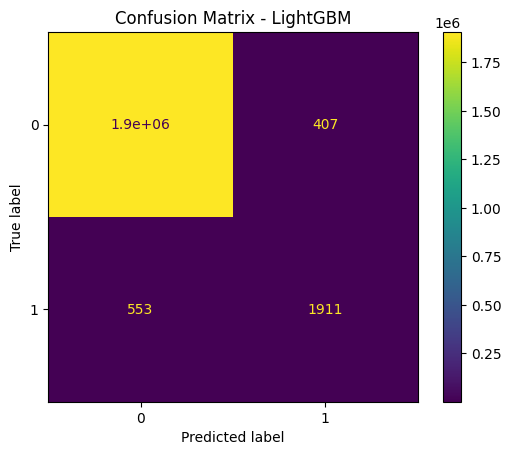

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.82      0.78      0.80      2464

    accuracy                           1.00   1908786
   macro avg       0.91      0.89      0.90   1908786
weighted avg       1.00      1.00      1.00   1908786

AUC-ROC Score: 94.46 %
➤➤➤ Precision Score :  99.95 %

➤➤➤ Recall Score :  99.95 %

➤➤➤ F1 Score :  99.95 %

➤➤➤ AUC-ROC Score : 94.46 %



In [14]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=[0, 1]).plot()
plt.title('Confusion Matrix - LightGBM')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# AUC-ROC Score
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f'AUC-ROC Score: {roc_auc * 100:.2f} %')

# Precision
Precision_LGBM = precision_score(y_test, y_pred, average='weighted')
print(f'➤➤➤ Precision Score : {Precision_LGBM * 100 : .2f} %\n')

# Recall
Recall_LGBM = recall_score(y_test, y_pred, average='weighted')
print(f'➤➤➤ Recall Score : {Recall_LGBM * 100 : .2f} %\n')

# F1 Score
F1_Score_LGBM = f1_score(y_test, y_pred, average='weighted')
print(f'➤➤➤ F1 Score : {F1_Score_LGBM * 100 : .2f} %\n')

# AUC-ROC Score (Binary classification only)
if len(np.unique(y_test)) == 2:
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    print(f'➤➤➤ AUC-ROC Score : {roc_auc * 100:.2f} %\n')

In [13]:
# Save the Booster model (if you want to save only the boosting part)
model.booster_.save_model('best_LGBM_booster.txt')


In [66]:
import lightgbm as lgb

# Load the saved model
loaded_model = lgb.Booster(model_file='best_LGBM_booster.txt')


In [69]:
y_pred_prob = loaded_model.predict(X_test_scaled)  # This gives probabilities


In [70]:
# Convert probabilities to binary predictions
threshold = 0.5  # You can adjust this to improve precision/recall
y_pred = (y_pred_prob >= threshold).astype(int)


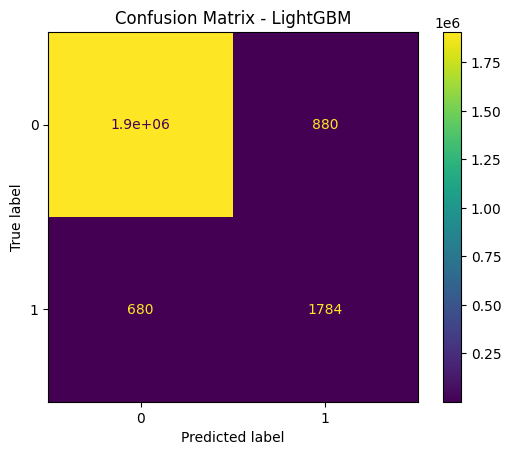

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.67      0.72      0.70      2464

    accuracy                           1.00   1908786
   macro avg       0.83      0.86      0.85   1908786
weighted avg       1.00      1.00      1.00   1908786

AUC-ROC Score: 88.90 %


In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=[0, 1]).plot()
plt.title('Confusion Matrix - LightGBM')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# AUC-ROC Score
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f'AUC-ROC Score: {roc_auc * 100:.2f} %')

In [56]:
import joblib

# Save the model to a file
joblib.dump(model, 'best_LGBM_model.pkl')



['best_LGBM_model.pkl']

In [58]:
import pickle
# OR if you used pickle
with open('best_LGBM_model.pkl', 'rb') as file:
    model = pickle.load(file)
